In [190]:
import io
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import math
#%matplotlib qt
%matplotlib inline

In [191]:
CH_data = pd.read_fwf("C:/Users/willi/Desktop/Savin Group/rate_CH.txt", widths = [13, 13, 13, 13])

CH2_data = pd.read_fwf("C:/Users/willi/Desktop/Savin Group/rate_CH2.txt", widths = [13, 13, 13, 13])
# 'voltage' 'energy' 'rate' 'uncertainty

In [192]:
def original(T, a_0, a_12, a_1, b_12, b_1, b_32):
    upper  = a_0 + (a_12)*(T**(1/2)) + a_1*T
    lower = T**(1/6) + (b_12)*(T**(1/2)) + (b_1)*(T) + (b_32)*(T**(3/2))
    value = upper/lower
    return value

In [193]:
temps = np.logspace(0, 4, 30000)

Statistical populations for each J-Level, and derived thermal rate coefficient


In [194]:
#from nist, 0->0, 1->16.41671  2->0.00538258776
#conversion factor = 0.000123984193

In [195]:
def population(T, J):
    energylist = [0, 0.00203541254, 5.4e-3]
    G = (2*J)+1
    Kb = 8.314e-5
    upper = G*np.exp(-1*energylist[J]/(Kb*T))
    lower = 0
    for Ji in range(3):
        value = ((2*Ji)+1)*np.exp(-1*energylist[Ji]/(Kb*T))
        lower += value
    return (upper/lower)

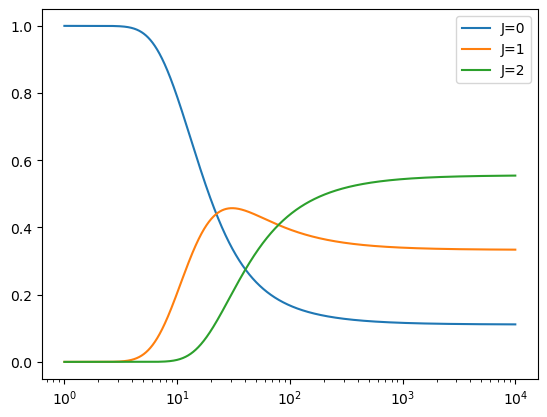

In [196]:
pop_0 = [population(temp, 0) for temp in temps]
plt.plot(temps, pop_0, label = "J=0")
pop_1 = [population(temp, 1) for temp in temps]
plt.plot(temps, pop_1, label = "J=1")
pop_2 = [population(temp, 2) for temp in temps]
plt.plot(temps, pop_2, label = "J=2")
plt.xscale("log")
plt.legend()

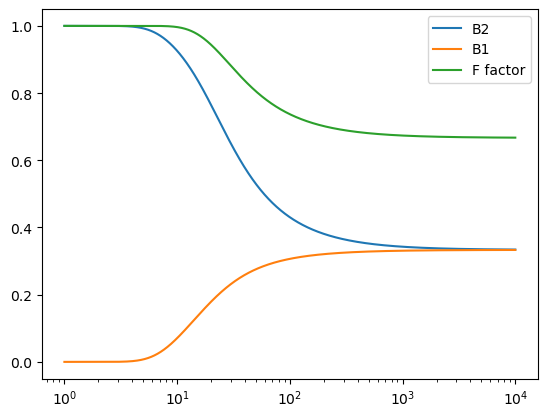

In [197]:
B2 = [pop_0[char] + (2/3)*pop_1[char] for char in range(len(temps))]
B1 = [(1/3)*pop_1[char] + (2/5)*pop_2[char] for char in range(len(temps))]
F = [B2[char] + B1[char] for char in range(len(temps))]
plt.plot(temps, B2, label = "B2")
plt.plot(temps, B1, label = "B1")
plt.xscale("log")
plt.plot(temps, F, label = "F factor")
plt.legend()

 C + H3+  ->  CH+ + H2
 Measured from 72 k to 10^4 K

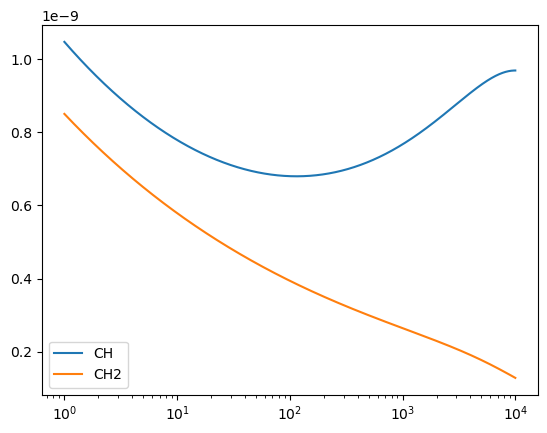

In [199]:
ratesCH = [original(temp, 1.0218E-09, 7.2733E-11, 5.9203E-14, 4.4914E-02, -2.6056E-04, 2.6397E-06) for temp in temps]    
ratesCH2 = [original(temp, 8.5145E-10, 0, 0, 9.5666E-04, -4.4040E-05, 2.3496E-06) for temp in temps]
    
plt.plot(temps, ratesCH, label = "CH")
plt.plot(temps, ratesCH2, label = "CH2")
plt.xscale("log")
plt.legend()

In [200]:
"""
Reaction 3 = CH
Reaction 5 = CH2
1. Sum coefficnts, and multiply by 3f/2 (gives both)
2. Multiply CH2 by 3*B2 -> gives CH2
3. Subtract to obtain CH
"""


'\nReaction 3 = CH\nReaction 5 = CH2\n1. Sum coefficnts, and multiply by 3f/2 (gives both)\n2. Multiply CH2 by 3*B2 -> gives CH2\n3. Subtract to obtain CH\n'

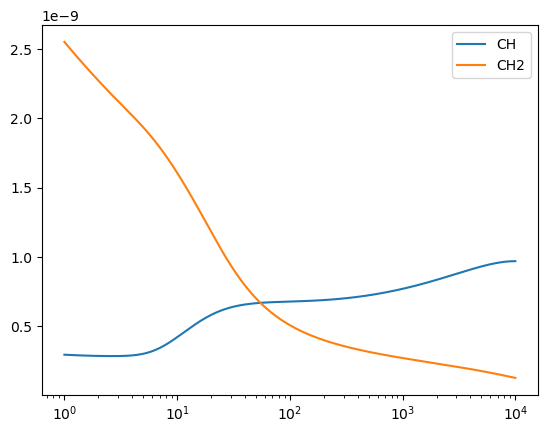

In [201]:
summed = [(ratesCH[char] + ratesCH2[char])*(3/2)*F[char]for char in range(len(temps))]
CH2_thermal = [ratesCH2[char]*3*B2[char]for char in range(len(temps))]
CH_thermal = [summed[char] - CH2_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH2_thermal, label = "CH2")
plt.xscale("log")
plt.legend()

In [202]:
def AK_1_fit(T, a, b, gamma):
    value = a * ((T/300)**b) * np.exp(-gamma/T)
    return value

def AK_2_fit(T, T1, a1, b1, gamma1, b2, gamma2):
    a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))
    return np.piecewise(T, [(T <= T1), (T> T1)], 
                        [lambda T:(a1 * ((T/300)**b1) * np.exp(-gamma1/T)), 
                         lambda T:(a2 * ((T/300)**b2) * np.exp(-gamma2/T))])

def AK_4_fit(T, T1, T2, a1, b1, gamma1, b2, gamma2, b3, gamma3):
    a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))
    a3 = (a2 * ((T2/300)**(b2-b3))*np.exp((gamma3-gamma2)/T2))
    return np.piecewise(T, [(T <= T1), (T> T1) & (T<=T2), (T>T2)], 
                        [lambda T:(a1 * ((T/300)**b1) * np.exp(-gamma1/T)), 
                         lambda T:(a2*((T/300)**b2) * np.exp(-gamma2/T)),
                         lambda T:(a3*((T/300)**b3) * np.exp(-gamma3/T))])

def AK_4_fit(T, T1, T2, T3, a1, b1, gamma1, b2, gamma2, b3, gamma3, b4, gamma4):
    a2 = (a1 * ((T1/300)**(b1-b2))*np.exp((gamma2-gamma1)/T1))
    a3 = (a2 * ((T2/300)**(b2-b3))*np.exp((gamma3-gamma2)/T2))
    a4 = (a3 * ((T3/300)**(b3-b4))*np.exp((gamma4-gamma3)/T3))
    return np.piecewise(T, [(T <= T1), (T> T1) & (T<=T2), (T>T2) & (T<=T3), T>T3], 
                        [lambda T:(a1 * ((T/300)**b1) * np.exp(-gamma1/T)), 
                         lambda T:(a2*((T/300)**b2) * np.exp(-gamma2/T)),
                         lambda T:(a3*((T/300)**b3) * np.exp(-gamma3/T)),
                         lambda T:(a4*((T/300)**b4) * np.exp(-gamma4/T))
                        ])

CH fits

In [203]:
poptCH, pcovCH = optimize.curve_fit(AK_1_fit, temps, CH_thermal, method="lm")
print(poptCH)

[7.16677917e-10 8.90444426e-02 1.01723812e+00]


C:\Users\willi\AppData\Local\Temp\ipykernel_34644\324692965.py:2: RuntimeWarning: overflow encountered in exp
  value = a * ((T/300)**b) * np.exp(-gamma/T)


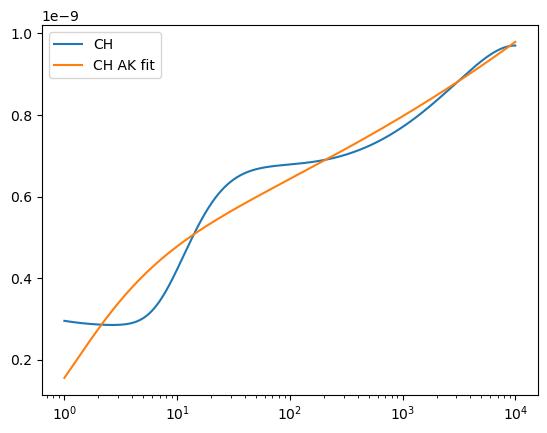

In [212]:
CH_1_AK = [AK_1_fit(temp, 7.16677917e-10, 8.90444426e-02, 1.01723812e+00) for temp in temps]
CH_1_AK_error = [100*(CH_1_line[char] - CH_thermal[char])/CH_thermal[char] for char in range(len(temps))]
plt.plot(temps, CH_thermal, label = "CH")
plt.plot(temps, CH_1_AK, label = "CH AK fit")
plt.xscale("log")
plt.legend()

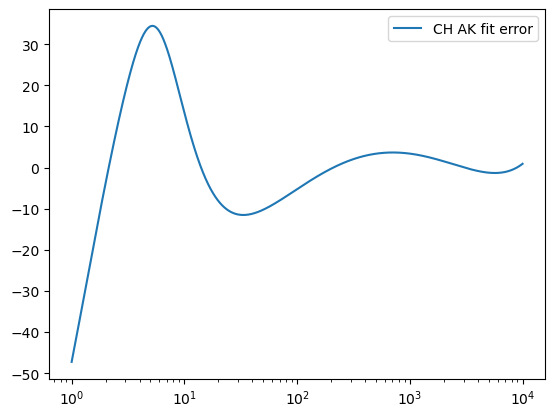

In [213]:
plt.plot(temps, CH_1_AK_error, label = "CH AK fit error")
plt.xscale("log")
plt.legend()